In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from adjustText import adjust_text # https://stackoverflow.com/questions/34693991/repel-annotations-in-matplotlib

import sys
sys.path.append('/rumi/shams/abe/CanDI/')
from CanDI import candi as can

In [60]:
# import stringdb

# def run_enrichment(genes):
#     string_ids = stringdb.get_string_ids(genes)
#     enrichment_df = stringdb.get_enrichment(string_ids.queryItem).sort_values('number_of_genes',ascending=False)
    
#     df = enrichment_df[[
#         'inputGenes','p_value','fdr','description','term','number_of_genes','number_of_genes_in_background'
#     ]]
    
#     return df

## CanDI analysis 

In [61]:
_ = can.data.load('mutations')

In [62]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))


def pretty_print_attr(obj):
    attr = []
    ls_attr = []
    meth = []
    for i in dir(obj):
        if "_" != i[0]:
            if type(getattr(obj, i)) == str or type(getattr(obj, i)) == int:
                attr.append(i)
            elif type(getattr(obj, i)) == list:
                ls_attr.append(i)
            else:
                meth.append(i)

    print("Attributes:\n")
    for i in attr: print(i+":", getattr(obj, i))
    for i in ls_attr: print(i+" list first item:", getattr(obj, i)[0])
    for i in ls_attr: print(i+" length:", len(getattr(obj, i)))
    print("\nMethods:\n")
    for i in meth: print(i)

In [329]:
def mt_wt_objs(cancer, mt_id_list):#genes):
    # Cell lines with mutation
    # mt_list = cancer.mutated(genes)
    mt = can.CellLineCluster(mt_id_list) 

    wt_id_list = list(set(cancer.depmap_ids) - set(mt_id_list)) 

    wt = can.CellLineCluster(wt_id_list) 
    print (f'#of mutated cell lines:\n\t{len(mt.depmap_ids)}')
    print (f'#of wildtype cell lines:\n\t{len(wt.depmap_ids)}')
    
    return mt, wt

In [262]:
def gene_effect_heatmap(obj1, obj2, genes, name = None, figsize=(16, 6)):
    #Make Figure appropriate size, dpi, and font
    plt.rcParams.update({"figure.figsize": figsize,
                        "savefig.dpi": 300,
                        "font.size": 8
                        })

    #One figure with one subplot
    fig, ax = plt.subplots(1,1)

    #Construcat matrix to make heatmap and cell line labels
    data = pd.concat([obj1.effect_of(genes), obj2.effect_of(genes)], axis=1)
    names = can.data.cell_lines.loc[data.columns, "cell_line_name"]

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(names)))
    ax.set_yticks(np.arange(len(genes)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(names)
    ax.set_yticklabels(genes)

    #make heatmap
    im = ax.imshow(data, cmap="RdBu")

    #Make colorbar scale to axis
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = ax.figure.colorbar(im, ax = ax, cax = cax)
    cbar.ax.set_ylabel("Gene Effect", rotation=-90, va="bottom")

    #Draw Dividing line btween mutant and
    ax.axvline(x=obj1.gene_effect.shape[1] - 0.5, c = "black", linewidth = 3)
    plt.setp(ax.get_xticklabels(), rotation=-90, ha="left", va="center",
         rotation_mode="anchor")
    plt.tight_layout()
    plt.show()

    if name:
        fig.savefig(name, dpi=300)

In [366]:
def gene_effect_scatter(obj1, obj2, genes=None, name_scatter='', return_data=False, return_plot=True, save_plot=None):

    # Average Gene Effect 
    if len(obj1.depmap_ids) > 1:
        obj1_effect = obj1.gene_dependency.mean(1)
    else:
        obj1_effect = obj1.gene_dependency

    if len(obj2.depmap_ids) > 1:
        obj2_effect = obj2.gene_dependency.mean(1)

    if return_data:
        return obj1_effect, obj2_effect
    
    if return_plot:
        #Make Figure appropriate size, dpi, and font
        plt.rcParams.update({"figure.figsize": (8, 8),
                            "savefig.dpi": 300,
                            "font.family": "sans-serif",
                            "font.size": 12
                            })

        #Generate Figure and Axis objects
        fig, ax = plt.subplots(1,1)

        #Label Axes
        ax.set_xlabel(f"{name_scatter} MT Average Gene Effect (CERES Score)")
        ax.set_ylabel(f"{name_scatter} WT Average Gene Effect (CERES Score)")

        #Draw Line at median common essential value
        ax.axhline(y = 0.50,
                   c = "black",
                   linewidth=0.5,
                   label = "Minimun Gene Dependencey Probability"
                  )

        ax.axvline(x = 0.50,
                   c= "black",
                   linewidth=0.5)

        #Plot all genes
        ax.scatter(obj1_effect,
                   obj2_effect,
                   c = "#2166ac",
                   alpha = 0.1,
                   s = 50
                  )

        ax.legend()

        if genes:
            #For Labeling
            if type(genes) != list:
                obj1_lab = obj1_effect.loc[[genes]]
                obj2_lab = obj2_effect.loc[[genes]]
            else:
                obj1_lab = obj1_effect.loc[genes]
                obj2_lab = obj2_effect.loc[genes]
            # Outline Genes To label
            ax.scatter(obj1_lab,
                       obj2_lab,
                       c = "#2166ac",
                       s = 50,
                       edgecolor = "black",
                       linewidth = 2,
                       alpha = 0.7
                      )
        #     for i in range(mt_lab.shape[0]):
        #         text = list(mt_lab.index)
        #         ax.annotate(text[i],
        #                     xy = (mt_lab[i], wt_lab[i]),
        #                     xytext = label[i],
        #                     xycoords = "data",
        #                     arrowprops = {"arrowstyle": "-"}
        #                    )
            texts = []
            for x, y, s in zip(obj1_lab,obj2_lab, obj1_lab.index.tolist()):
                texts.append(plt.text(x, y, s))

            adjust_text(
                texts, force_points=0.2, force_text=0.1,
                expand_points=(2, 2), 
                expand_text=(2, 2),
                arrowprops=dict(arrowstyle="-", color='black', lw=0.2)
            )

        plt.show()

        if save_plot:
            fig.savefig(save_plot, dpi=300)

In [65]:
cell_lines = can.data.cell_lines
genes = can.data.genes.index.tolist()

In [125]:
# Sara: PRDX1, RAD51, ATM, ATRX

In [246]:
import os, inspect, sys
sys.path.append('/rumi/shams/abe/Projects/ipage-down/')
import ipage_down as ipd

gs_clst= 'msigdb_v7.4_c5.go'
ANNDIR = f'{os.path.dirname(inspect.getfile(ipd))}/annotations'

pws = {}

for pattern in ['REPAIR','DAMAGE','BREAK']:
    for gs in ipd.search_page_names(pattern,f'{ANNDIR}/{gs_clst}/{gs_clst}_names.txt'):
        pws.update(
            ipd.read_page_annotations(
                gs[0], gs_clst,ANNDIR,
                gz=False
            )
        )

In [123]:
# help(ipd)

In [161]:
Sara_genes = ['PRDX1','RAD51', 'ATM', 'ATRX']

In [126]:
lung = can.Cancer("Lung Cancer", subtype="NSCLC")

In [328]:
lung.subtypes

array(['Non-Small Cell Lung Cancer (NSCLC), Adenocarcinoma',
       'Non-Small Cell Lung Cancer (NSCLC), Large Cell Carcinoma',
       'Non-Small Cell Lung Cancer (NSCLC), unspecified',
       'Non-Small Cell Lung Cancer (NSCLC), Squamous Cell Carcinoma',
       'Non-Small Cell Lung Cancer (NSCLC), Adenosquamous Carcinoma',
       'Non-Small Cell Lung Cancer (NSCLC), Mucoepidermoid Carcinoma'],
      dtype=object)

In [137]:
cell_lines.loc[lung.depmap_ids].shape[0]

186

## Find mutated cell lines 

In [1]:
set(can.data.mutations.Variant_Classification)

NameError: name 'can' is not defined

__loss-of-function mutations (?):__
- De_novo_Start_OutOfFrame
- Frame_Shift_Del
- Frame_Shift_Ins
<!-- - Missense_Mutation -->
- Nonsense_Mutation
- Nonstop_Mutation
- Start_Codon_Del

In [310]:
dict(
    [
        (gene, 
         dict([(i,n) for i,n in zip(ids, cell_lines.cell_line_name[ids].tolist())])
        )
        
        for gene,ids in lung.mutated(Sara_genes,output='dict').items()
    ]
)

{'ATM': {'ACH-000030': 'PC-14',
  'ACH-000327': 'NCI-H1395',
  'ACH-000343': 'NCI-H522',
  'ACH-000395': 'NCI-H520',
  'ACH-000448': 'NCI-H1666',
  'ACH-000563': 'EBC-1',
  'ACH-000627': 'LCLC-103H',
  'ACH-000675': 'NCI-H1734',
  'ACH-000690': 'HCC-2814',
  'ACH-000700': nan,
  'ACH-000733': 'NCI-H1838',
  'ACH-000747': 'NCI-H1703',
  'ACH-000779': nan,
  'ACH-000787': 'LXF-289',
  'ACH-000789': 'NCI-H810',
  'ACH-000840': 'HCC-366',
  'ACH-000841': 'NCI-H2087',
  'ACH-000843': 'HARA',
  'ACH-000845': 'NCI-H1373',
  'ACH-000869': 'NCI-H1568',
  'ACH-000900': 'NCI-H23',
  'ACH-000924': 'NCI-H2172',
  'ACH-000929': 'NCI-H2110',
  'ACH-000945': 'NCI-H650',
  'ACH-000975': nan},
 'ATRX': {'ACH-000186': 'NCI-H2444',
  'ACH-000578': 'HCC-1171',
  'ACH-000603': 'BEN',
  'ACH-000700': nan,
  'ACH-000851': 'MOR/CPR',
  'ACH-000853': 'NCI-H661',
  'ACH-000875': 'NCI-H2347',
  'ACH-000901': 'HCC-1359',
  'ACH-000925': 'DV-90',
  'ACH-000980': 'NCI-H1155'},
 'PRDX1': {'ACH-000904': 'NCI-H2106'}}

In [292]:
# help(lung.mutated)
mt_df = lung.mutated(Sara_genes,output='dataframe')

mt_df = mt_df.loc[[var in [
    'De_novo_Start_OutOfFrame',
    "Frame_Shift_Ins",
    "Frame_Shift_Del",
    "Missense_Mutation",
    "Nonsense_Mutation",
    "Nonstop_Mutation",
    "Start_Codon_Del"
] for var in mt_df.Variant_Classification],]

mt_df.groupby(['gene',"Variant_Type"]).sum().index

MultiIndex([(  'ATM', 'DNP'),
            (  'ATM', 'INS'),
            (  'ATM', 'SNP'),
            ( 'ATRX', 'DEL'),
            ( 'ATRX', 'INS'),
            ( 'ATRX', 'SNP'),
            ('PRDX1', 'SNP')],
           names=['gene', 'Variant_Type'])

# Analyzing Global Gene Dependency


> #### [Note-about-Gene-Effect-Scores:-Dependency-vs-Essentiality:](https://candi.readthedocs.io/en/latest/kras_egfr_scatter.html#Note-about-Gene-Effect-Scores:-Dependency-vs-Essentiality) 
A more negative gene effect means more dependent. A gene effect of -1.0 is the median gene effect of all common essential genes. If a gene has a gene effect of -1.0 or lower it then that gene is essential. A cell line can still be dependent on a gene with a lower gene effect if knocking out that gene slows growth/proliferation.



In [333]:
mt, wt = mt_wt_objs(lung, mt_df.DepMap_ID.tolist())

#of mutated cell lines:
	42
#of wildtype cell lines:
	152


In [331]:
# gene_effect_heatmap(mt, wt,list({gene for pw, ann in pws.items() for gene in ann['genes']}), figsize=(150, 50))

#### Scatter plot

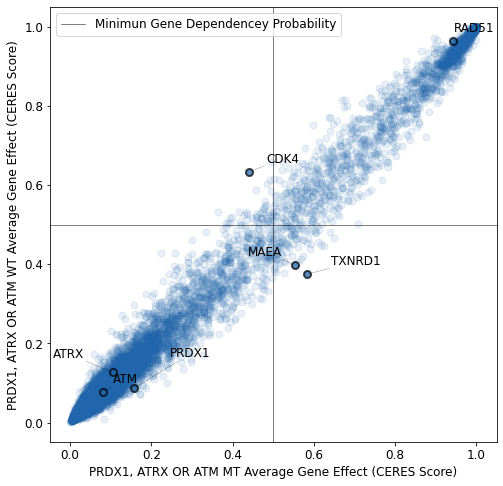

In [347]:
mt_effect, wt_effect = gene_effect_scatter(
    mt, wt,return_data=True,return_plot=False
)

labels = intersection (
    mt_effect[mt_effect <= 0.45].index.tolist(),
    wt_effect[wt_effect >= 0.6].index.tolist()
) + intersection (
    mt_effect[mt_effect >= 0.55].index.tolist(),
    wt_effect[wt_effect <= 0.4].index.tolist()
)

labels

gene_effect_scatter(
    mt, wt,
    genes=labels + Sara_genes,
    name_scatter='PRDX1, ATRX OR ATM',
    save_plot='PRDX1-ATRX-or-ATM-scatter.pdf'
)

# run_enrichment(labels)

#### PRDX1

In [359]:
prdx1_mt, prdx1_wt = mt_wt_objs(mt, list(lung.mutated(Sara_genes,output='dict')['PRDX1']))

#of mutated cell lines:
	1
#of wildtype cell lines:
	33


In [376]:
prdx1_mt.depmap_ids[0] in  lung.gene_dependency.columns

False

In [377]:
prdx1_mt.depmap_ids[0] in  mt_df.DepMap_ID.tolist()

True

In [378]:
# prdx1_wt.gene_dependency#.mean(1)

In [379]:
# mt_effect, wt_effect = gene_effect_scatter(
#     prdx1_mt, prdx1_wt,return_data=True,return_plot=False
# )

# labels = intersection (
#     mt_effect[mt_effect <= 0.45].index.tolist(),
#     wt_effect[wt_effect >= 0.6].index.tolist()
# ) + intersection (
#     mt_effect[mt_effect >= 0.55].index.tolist(),
#     wt_effect[wt_effect <= 0.4].index.tolist()
# )

# labels = []

# gene_effect_scatter(
#     mt_effect, wt_effect,
#     # genes=labels + Sara_genes,
#     name_scatter='PRDX1, ATRX OR ATM',
#     # save_plot='PRDX1-scatter.pdf'
# )

# # run_enrichment(labels)

### DESeq analysis

In [348]:
def make_counts_coldata(obj1, obj2, condition, factor1, factor2):

    counts1 = obj1.rnaseq_reads
    coldat1 = pd.Series(counts1.shape[1] * [factor1], index = counts1.columns, name = condition)

    counts2 = obj2.rnaseq_reads
    coldat2 = pd.Series(counts2.shape[1] * [factor2], index = counts2.columns, name = condition)

    #Concatenate Column Data
    coldat = pd.concat([coldat1, coldat2], axis = 0)
    #Concatenate read count data
    counts_mat = pd.concat([counts1, counts2], axis = 1)
    #Sum duplicate indeces
    counts_mat = counts_mat.groupby(counts_mat.index).sum().astype(int)

    return counts_mat, coldat

In [349]:
counts_mat, coldat = make_counts_coldata(mt, wt,'mutation','mt','wt')

In [350]:
coldat.describe()

count     143
unique      2
top        wt
freq      101
Name: mutation, dtype: object

In [92]:
!date

Mon Nov  8 07:21:48 UTC 2021
